# Imports

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Density of States

In [78]:
# Graphene bands (length in units of a and energy in units of t)
def energy_band(kx, ky):
    term1 = np.cos(kx * np.sqrt(3))
    term2 = np.cos(kx * np.sqrt(3) / 2) * np.cos(ky * 3 / 2)
    return np.sqrt(3 + 2 * term1 + 4 * term2)


def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))


def dosExact(ee, Nk = 500, Maxk = 10, sigma = 0.02):
    # Generate mesh
    u = np.linspace(-Maxk, Maxk, Nk)
    v = np.linspace(-Maxk, Maxk, Nk)
    uu, vv = np.meshgrid(u, v)

    # Calculate eigenvalues
    bb = energy_band(uu, vv).flatten()
    bb = list(bb) + list(-bb)

    # Calculate DOS
    dataExact = np.zeros_like(ee)
    for energy in bb:
        dataExact += gaussian(ee, energy, sigma)
    
    return dataExact / Nk**2

# Data Files

In [79]:
import glob


def cheb(n: int, x: float | np.ndarray) -> float | np.ndarray:
    return np.cos(n * np.arccos(x))


# Find all text files starting with "out"
fileListData = glob.glob("out*.txt")

# Array with the energy values
points = 800
ee = np.linspace(-1, 1, points)

# If all energy scales are the same, we can pre-compute the exact DOS
dosExactPre = dosExact(ee * 4 * 1.0001)

# Organize the data into arrays
dataArr = []
for file in fileListData:
    _, L, t, w, NAverages, Nmoments = file.split("-")
    L, t, w, NAverages, Nmoments = int(L), float(t), float(w), int(NAverages), int(Nmoments[:-4])
    
    # Load the file as an array of floats
    dataNum = np.genfromtxt(file, dtype=float)
    dataNum = dataNum.T

    # Normalize energies
    wt = w / t

    # Clip for Chebyshev polynomials
    eecc = ee[1:-1]

    # Get chebyshev coeffcients
    mm = dataNum
    
    # Compute the DOS
    rho = np.zeros(len(eecc))
    rho = mm[0] * (1/np.pi) * 1 / np.sqrt(1 - eecc**2)
    for n in range(1, Nmoments):
        rho += mm[n] * (2/np.pi) * 1 / np.sqrt(1 - eecc**2) * cheb(n, eecc)
    
    # Rescale data
    energy_scale = (4 + wt/2) * 1.0001
    eedata = ee * energy_scale
    rho /= energy_scale

    # Store
    dataNum = [0] + list(rho) + [0]
    dataArr += [(L, wt, NAverages, Nmoments, eedata, dataNum, dosExactPre)]


# Find all text files starting with "time"
fileListTime = glob.glob("time*.txt")

# Get time data
ttArr, rrArr, uuArr = [], [], []
for fileName in fileListTime:
    with open(fileName, "r") as file:
        text = file.read().split("\n")
        text = [item for item in text if len(item) > 2]

    tt, rr, uu = [], [], []
    # Timing with time function
    # for index in range(len(text) // 4):
    #     index *= 4
    #     tt += [int(text[index].split("=")[-1])]
    #     rr += [float(text[index + 1].split("m")[-1][:-1])]
    #     uu += [float(text[index + 2].split("m")[-1][:-1])]

    # Timing itself
    for item in text:
        item = item.split()
        tt += [int(item[5][:-1])]
        rr += [float(item[6])]

    ttArr += [tt]
    rrArr += [rr]
    uuArr += [uu]

ttArr = np.array(ttArr)
rrArr = np.array(rrArr)
uuArr = np.array(uuArr)

# Visualization

In [80]:
def plotAll(dataArr: list, cols: int) -> None:
    # Needed number of columns
    rows = len(dataArr) // cols + 1
    for index, item in enumerate(dataArr):
        # Getting data
        L, wt, NAverages, Nmoments, eedata, dataNum, dataThermo = item

        # Plotting
        plt.title(f"Density of States for $L$ = {L} and $w/t$ = {wt} with {NAverages} Averages and {Nmoments} Moments")
        plt.plot(eedata, dataNum, label="Calculated DOS")
        plt.plot(eedata, dataThermo, label="Thermodynamic DOS")
        plt.xlabel("$\\varepsilon$ (Same units as t)")
        plt.ylabel("$\\rho(\\varepsilon)$ (Same units as 1/t)")
        plt.legend()
        plt.show()

        # Analysis
        diff = dataNum - dataThermo
        print(f"Density of States for $L$ = {L} and $w/t$ = {wt} with {NAverages} Averages and {Nmoments} Moments")
        print(f"Maximum difference is {np.max(np.abs(diff))}")
        print(f"Average difference is {np.mean(diff)}")
        print(f"Std of difference is {np.std(diff)}")
        print("\n\n")    

    plt.show() 

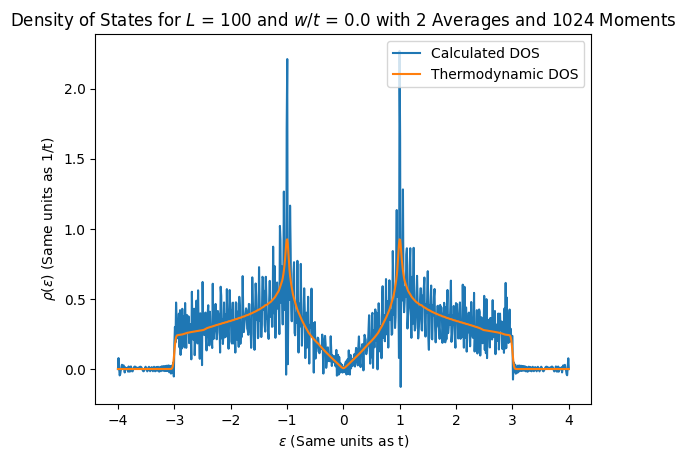

Density of States for $L$ = 100 and $w/t$ = 0.0 with 2 Averages and 1024 Moments
Maximum difference is 1.3442446089755449
Average difference is -5.3801814937832205e-05
Std of difference is 0.1593073459016162





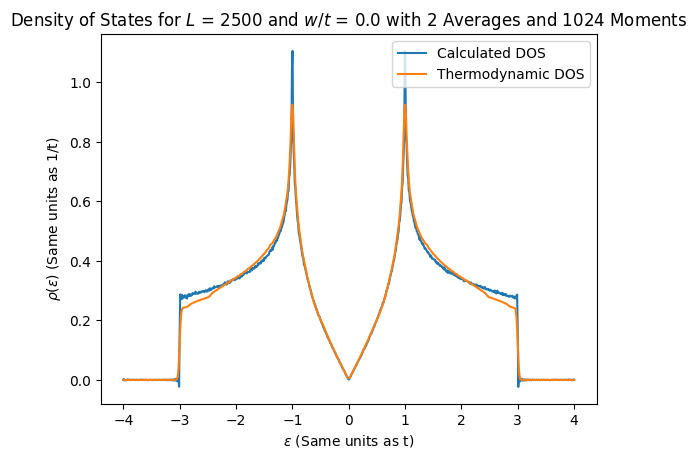

Density of States for $L$ = 2500 and $w/t$ = 0.0 with 2 Averages and 1024 Moments
Maximum difference is 0.18055485334116017
Average difference is 5.8885185904007374e-05
Std of difference is 0.021326640949894515





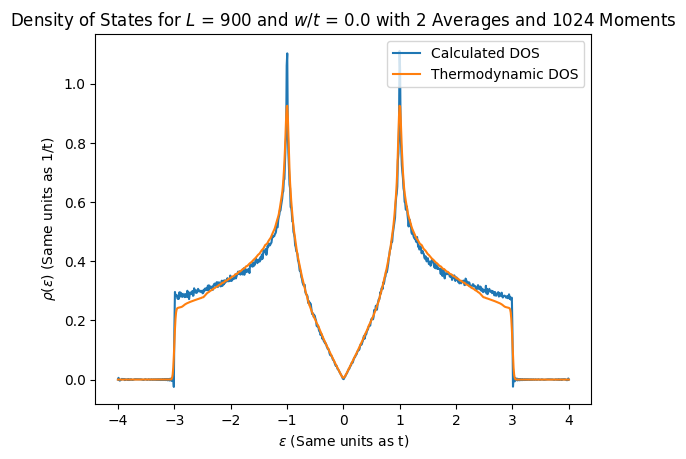

Density of States for $L$ = 900 and $w/t$ = 0.0 with 2 Averages and 1024 Moments
Maximum difference is 0.18527805913286488
Average difference is 0.00011031016493160739
Std of difference is 0.02208940950268252





In [81]:
plotAll(dataArr, 2)

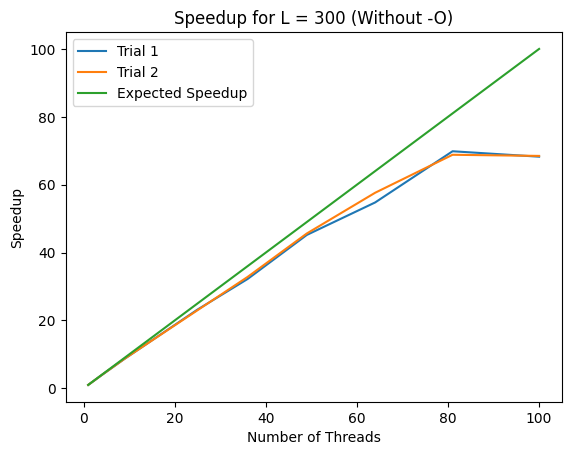

In [82]:
plt.title(f"Speedup for L = 300 (Without -O)")
for tt, rr, index in zip(ttArr, rrArr, range(0, len(ttArr))):
    plt.plot(tt, rr[0] / rr, label=f"Trial {index+1}")

plt.plot(tt, tt, label="Expected Speedup")
plt.xlabel("Number of Threads")
plt.ylabel("Speedup")
plt.legend()